In [91]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import random as ran
from IPython.display import clear_output
from src import spotify, dp, utils, DB
from sklearn.metrics.pairwise import euclidean_distances as euc
import pandas as pd
import math as mt
import numpy as np

db = DB()

# K Checking
- 새로운 K의 갯수를 만들 수 있는지 확인하는 과정

In [93]:
seed_musics = db.seed_zone.estimated_document_count()
K = round(mt.sqrt(seed_musics / 2))
print("현재 seed 음악 갯수 : {}".format(seed_musics))
print("K 갯수 : {}".format(K))

현재 seed 음악 갯수 : 327
K 갯수 : 13


In [94]:
_seed_features = db.seed_zone.find({})
seed_features = pd.DataFrame([_ for _ in _seed_features])

seed_features.drop(["_id"], axis=1, inplace=True)
seed_features.rename({"track_id": "id"}, axis=1,inplace=True)

seed_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,0.632,0.0378,5,-20.596,0.0583,0.9890,0.935000,0.1120,0.357,121.361
1,3UPjb91Fwm7u2tAm92Bk0p,0.554,0.5260,7,-5.210,0.0394,0.8080,0.000000,0.0740,0.230,129.845
2,3dbLT62Cvs46Ju7a8gpr36,0.727,0.8790,9,-1.167,0.1290,0.1240,0.000012,0.2440,0.671,146.959
3,2FWquqPNxte8iqZ3ATQG0p,0.403,0.7240,8,-6.064,0.2460,0.3770,0.000000,0.0927,0.428,97.133
4,3gzIK2dGSVvPBiohsTwEWZ,0.639,0.5690,0,-7.236,0.0487,0.0581,0.000169,0.1080,0.616,142.967


# Make Norm Features

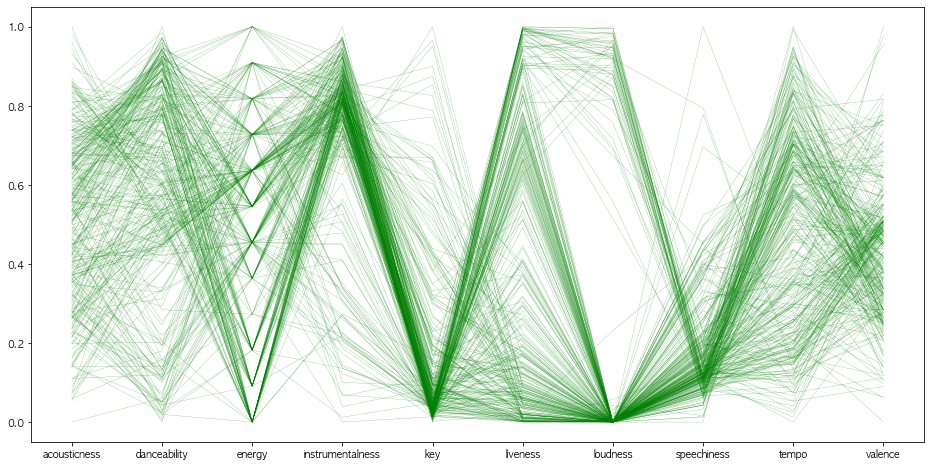

In [95]:
norm_features = dp.make_norm(seed_features)

utils.visual_norm_data(None, norm_features)

# KMeans Run

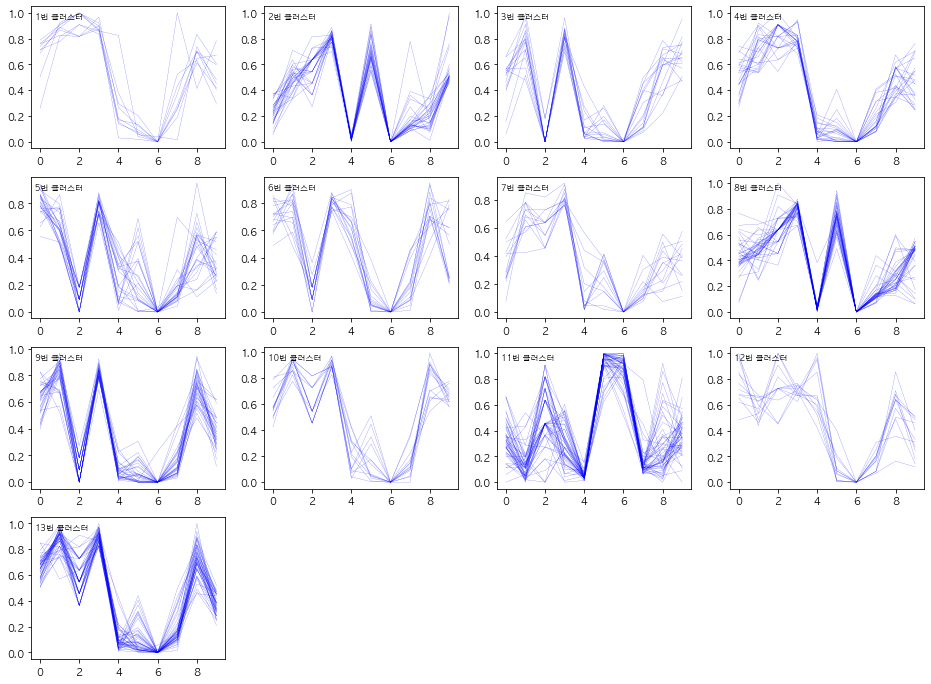

In [136]:
kmeans = utils.KMeans(
    datas=norm_features
)
kmeans.run(early_stop_cnt=5)

clear_output(wait=True)

_label = kmeans.clusters
utils.visual_cluster_data(norm_features, kmeans)

# Clustering 정렬

In [139]:
euc_scores = np.array([])
k_pat = kmeans.K_pattern
for idx in range(0, len(k_pat)):
    sel_k_pat = np.expand_dims(k_pat[idx], axis=0)

    print("Select K {}".format(idx))
    print("Select K pat {}".format(sel_k_pat))
    
    euc_scores = np.append(euc_scores,
                           euc(sel_k_pat,k_pat)[0].sum())
    
    

Select K 0
Select K pat [[0.6583409  0.86679012 0.91919192 0.88778465 0.27123179 0.09006211
  0.00456292 0.3691943  0.66486656 0.52341755]]
Select K 1
Select K pat [[2.27144602e-01 4.91195846e-01 5.67398119e-01 8.11782132e-01
  2.36185698e-02 7.05301842e-01 9.20360386e-06 1.78376205e-01
  1.92079126e-01 5.58551079e-01]]
Select K 2
Select K pat [[0.47454019 0.76231567 0.02272727 0.82066118 0.11449795 0.09079416
  0.00142026 0.25279087 0.56616288 0.66893717]]
Select K 3
Select K pat [[5.02487857e-01 7.16417168e-01 8.14229249e-01 7.96519523e-01
  7.15653956e-02 8.47314055e-02 1.58624937e-04 1.85799187e-01
  4.72937773e-01 4.64262060e-01]]
Select K 4
Select K pat [[0.80222525 0.62994261 0.08712121 0.78454223 0.24564549 0.24663315
  0.00191278 0.16497147 0.46508825 0.358162  ]]
Select K 5
Select K pat [[7.01379428e-01 7.52103672e-01 1.42045455e-01 8.12493174e-01
  6.43794826e-01 1.01269027e-01 2.34129066e-06 2.09059477e-01
  7.37074590e-01 4.93112333e-01]]
Select K 6
Select K pat [[3.439530

In [140]:
sort_scores = euc_scores.argsort()
sort_scores

array([ 6, 12,  3,  9,  4,  8,  2,  0,  7,  5, 11,  1, 10])

In [143]:
change_index_info = list()

for idx,_ in enumerate(sort_scores):
    change_index_info.append({
        "idxes": np.where(_label == _)[0],
        "change": idx
    })

In [144]:
print("변화 전")
print(_label)

변화 전
[10  7  0  6  2 10  7  7  1  7 10 10 10  7  7  7 12 11 11  0 12  0 12  6
 11 10 10 10 10  5  2  8  8  1  7  7  7 10  6  1  7  7  1  7  1 10  7 10
  1 12  1  7 11  0 12 12 12  0 12  3 10 10 11 10 10 10 10 10  7  1  1  1
  1 10 10 10 10  7  7  7  7  1  7  1 11 11  0  3 12  9  3  6 10 10 10 10
 10 10  7  1  7  8  8  1  7  8  8  8  7  4  5  9  6 12  8 12  7  7  1  3
 10  3  4  4  5  2  2  7 12 12  4  5  1  8  1  8  4  5  5  4  1 12 12 12
 12  7 12  8  8  8  8  7  1 10  3  3  3  3 10  4  4  8  5  5  4  6  6  9
 12 12 12 12 12 12  4  4  5  4  1  5 12  6  3  3 12 12  6  8  7  1 12  4
  9 12 12 12 12  7 12  8  8  8  8  1  7 10  3 10  3  3  3  5  4  4  2  8
  2 11  1  9  9 12 12  9 11  4  4  7  8  0  0 12 12  9 12  8  2  8  7  1
  1  3  3 10  3  3  3  2  4  5  2  4  8  2  2  8  8  2  1  1 11  1  9 12
 12 12  9 12 12  2  4  2  6  6 10  8  5 10  5 10 10  5  8  6 11  2  9 10
  4 10  4  3 12  3 10 10  6  0  4 11 12 10 10 10  9 12  7 10  7  9 10 10
  3 10  4 10  8  5 10 10  7  7  2  8  8  9 12]

In [145]:
for info in change_index_info:
    _label[info['idxes']] = info['change']

In [146]:
print("변화 후")
print(_label)

변화 후
[12  8  7  0  6 12  8  8 11  8 12 12 12  8  8  8  1 10 10  7  1  7  1  0
 10 12 12 12 12  9  6  5  5 11  8  8  8 12  0 11  8  8 11  8 11 12  8 12
 11  1 11  8 10  7  1  1  1  7  1  2 12 12 10 12 12 12 12 12  8 11 11 11
 11 12 12 12 12  8  8  8  8 11  8 11 10 10  7  2  1  3  2  0 12 12 12 12
 12 12  8 11  8  5  5 11  8  5  5  5  8  4  9  3  0  1  5  1  8  8 11  2
 12  2  4  4  9  6  6  8  1  1  4  9 11  5 11  5  4  9  9  4 11  1  1  1
  1  8  1  5  5  5  5  8 11 12  2  2  2  2 12  4  4  5  9  9  4  0  0  3
  1  1  1  1  1  1  4  4  9  4 11  9  1  0  2  2  1  1  0  5  8 11  1  4
  3  1  1  1  1  8  1  5  5  5  5 11  8 12  2 12  2  2  2  9  4  4  6  5
  6 10 11  3  3  1  1  3 10  4  4  8  5  7  7  1  1  3  1  5  6  5  8 11
 11  2  2 12  2  2  2  6  4  9  6  4  5  6  6  5  5  6 11 11 10 11  3  1
  1  1  3  1  1  6  4  6  0  0 12  5  9 12  9 12 12  9  5  0 10  6  3 12
  4 12  4  2  1  2 12 12  0  7  4 10  1 12 12 12  3  1  8 12  8  3 12 12
  2 12  4 12  5  9 12 12  8  8  6  5  5  3  1]

In [147]:
kmeans.clusters = _label
kmeans.K_pattern = k_pat[sort_scores]

In [148]:
np.where(_label == sort_scores[0])

(array([  4,  30, 125, 126, 214, 216, 236, 247, 250, 253, 254, 257, 269,
        271, 285, 322]),)

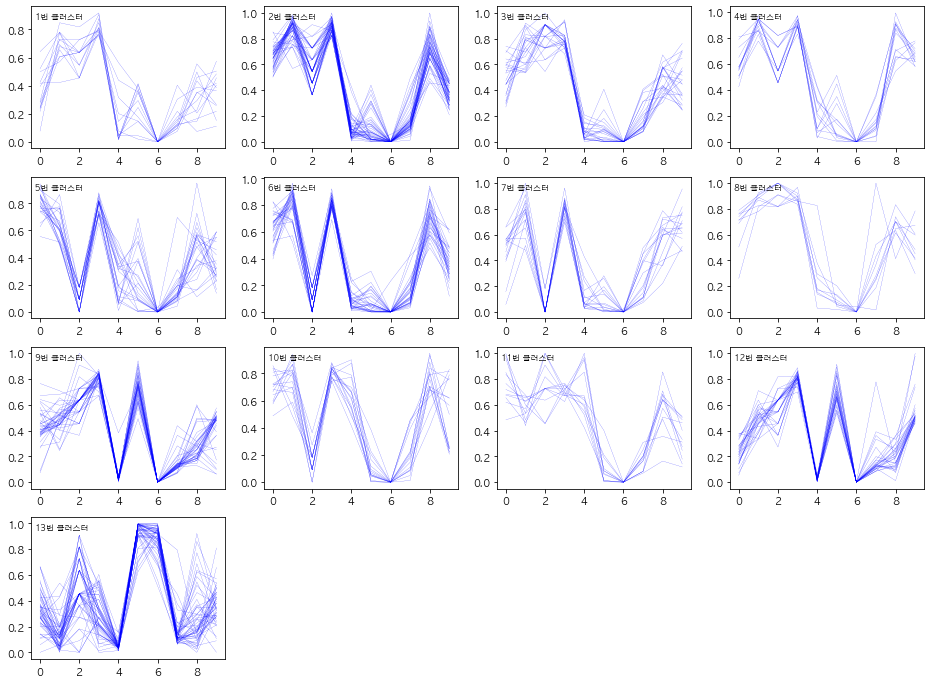

In [149]:
utils.visual_cluster_data(norm_features, kmeans)

# Mail Box Matching

In [150]:
music_label = pd.DataFrame(norm_features['id'])
music_label['label'] = _label

music_label.rename({"id": "track_id"}, axis=1,inplace=True)
music_label.head()

,track_id,label
0,7tIOwGFRTM08JdAeKOELGp,12
1,3UPjb91Fwm7u2tAm92Bk0p,8
2,3dbLT62Cvs46Ju7a8gpr36,7
3,2FWquqPNxte8iqZ3ATQG0p,0
4,3gzIK2dGSVvPBiohsTwEWZ,6


In [151]:
_mail_boxes = db.mail_box.find()
mail_boxes = [_ for _ in _mail_boxes]

mail_box_radar = pd.DataFrame(columns=set(_label))

for target_mail_box in mail_boxes:
    target = pd.DataFrame(target_mail_box['tracks'])
    target_label_info = pd.merge(target, music_label,
        on='track_id')
    group_cnt = target_label_info.groupby(['label']).count()['track_id']
    
    mail_box_radar.loc[str(target_mail_box['_id'])] = (group_cnt / len(target_label_info) * 100).round().astype("int")
    
mail_box_radar.fillna(0, inplace=True)
mail_box_radar = mail_box_radar.astype("int")
mail_box_radar.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
623f2515ff1c441a392ab38c,0,0,0,0,0,0,0,0,0,0,0,0,100
623f2515ff1c441a392ab38d,6,0,0,0,0,0,0,6,50,0,0,38,0
623f2515ff1c441a392ab38e,0,0,0,0,0,0,0,0,35,0,0,15,50
623f2515ff1c441a392ab38f,0,11,0,0,0,0,0,6,56,0,0,28,0
623f2515ff1c441a392ab390,14,0,0,0,0,0,0,14,0,0,71,0,0


In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [153]:
def getRadianFromAngle(angle):
    return pi / 180 * angle


def getX(distance, angle):
    rad = getRadianFromAngle(angle)
    return distance * mt.cos(rad)

def getY(distance, angle):
    rad = getRadianFromAngle(angle)
    return distance * mt.sin(rad)

In [154]:
mail_box_radar = mail_box_radar + 0.1

In [155]:
# ## 따로 그리기
# labels = mail_box_radar.columns
# num_labels = len(labels)
    
# angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
# angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
# my_palette = plt.cm.get_cmap("rainbow", len(mail_box_radar))
 
# fig = plt.figure(figsize=(15,20))
# fig.set_facecolor('white')
 
# for i, row in enumerate(mail_box_radar.values):
#     color = my_palette(i)
#     data = row.tolist()
#     data += data[:1] # 원점 데이터
    
#     ax = plt.subplot(round(K/ 2) + 1,2,i+1, polar=True)
#     ax.set_theta_offset(pi / 2) ## 시작점
#     ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
#     plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
#     ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
 
#     ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
#     plt.yticks(range(0, 100, 10),[str(_) for _ in range(0,100,10)], fontsize=10) ## y축 눈금 설정
#     plt.ylim(0,100)
    
#     ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') ## 레이더 차트 출력
#     ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
#     plt.title(mail_box_radar.index[i], size=20, color=color,x=-0.2, y=1.2, ha='left') ## 타이틀은 캐릭터 클래스로 한다.
 
# plt.tight_layout(pad=5) ## subplot간 패딩 조절
# plt.show()

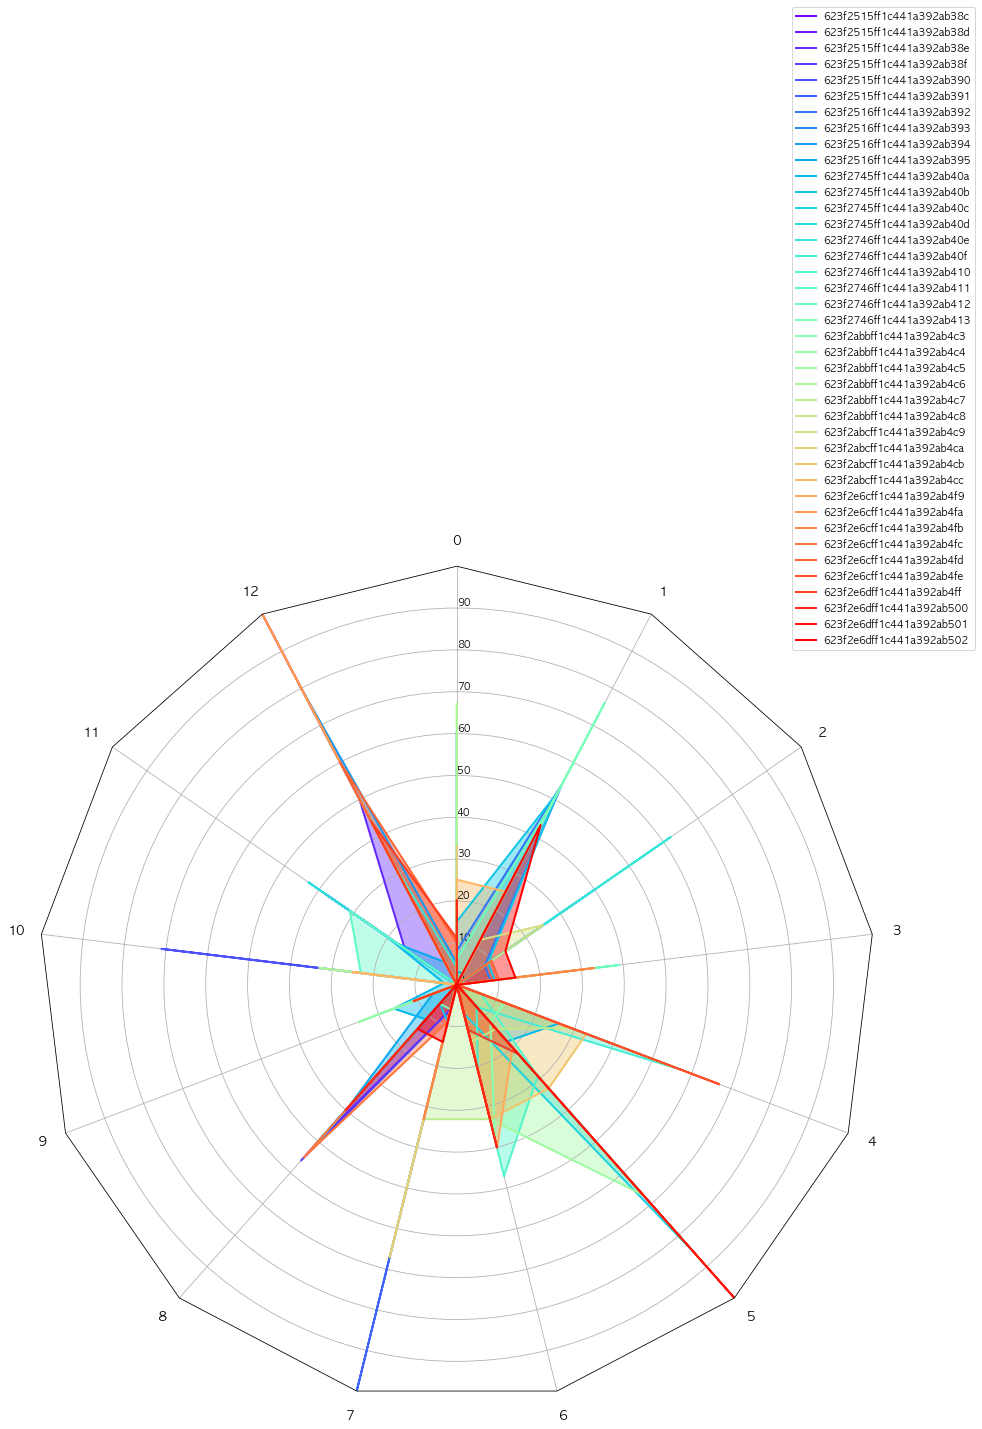

In [156]:
## 따로 그리기
labels = mail_box_radar.columns
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("rainbow", len(mail_box_radar))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
ax = fig.add_subplot(polar=True)

for i, row in enumerate(mail_box_radar.values):
    color = my_palette(i)
    data = row.tolist()
    data += data[:1] # 원점 데이터
    
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks(range(0, 100, 10),[str(_) for _ in range(0,100,10)], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,100)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid',
            label=mail_box_radar.index[i]) ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
for g in ax.yaxis.get_gridlines(): ## grid line 
    g.get_path()._interpolation_steps = len(labels)
    
spine = Spine(axes=ax,
          spine_type='circle',
          path=Path.unit_regular_polygon(len(labels)))
 
## Axes의 중심과 반지름을 맞춰준다.
spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)
           
ax.spines = {'polar':spine} ## frame의 모양을 원에서 폴리곤으로 바꿔줘야한다.
 
plt.legend(loc=(0.9,0.9))
plt.show()

In [157]:
quadrant_check = [[1, 1], [1, -1],[-1, -1], [-1,1]]

def get_quadrant(angle):
    chk_angle = [0, 90, 180, 270]
    if angle in chk_angle:
        return -1
    else:
        if angle < 90:
            return 0
        elif angle < 180:
            return 1
        elif angle < 270:
            return 2
        elif angle < 360:
            return 3
        
def check_guadrant(angle, point):
    if angle == 0:
        return [0, point[1]]
    elif angle == 90:
        return [point[1],0]
    elif angle == 180:
        return [0, point[1] * -1]
    elif angle == 270:
        return [point[1] * -1, 0]


In [158]:
cent_points = list()
mail_box_ids = mail_box_radar.index.values
for b_id in mail_box_ids:
    test = mail_box_radar.loc[b_id]
    non_zero_labels = test != 0

    sel_idx = test[non_zero_labels].index.values
    x = np.array(angles)[sel_idx]
    y = test[sel_idx].values
    
    point = np.array([[x[i], y[i]] for i,_ in enumerate(x)])
    
    point = point.reshape(-1, 2)

    for idx,pt in enumerate(point):  
        rad = pt[0]
        ang = rad / pi * 180
        dis = pt[1]
        quad = get_quadrant(ang)
        if quad == -1:
            point[idx] = check_guadrant(ang, pt)
        else:
            ang = ang % 90
            rad = ang * pi / 180
            
            quad = quadrant_check[quad]
            x = dis * mt.cos(rad) * quad[0]
            y = dis * mt.sin(rad) * quad[1]
            
            point[idx] = [x,y]
    point = point.reshape(-1, 2)
    point = point.reshape(-1, 2)
    
    cent_points.append(point.sum(axis=0))
    
cent_points = np.array(cent_points)

cent_points

array([[-46.56661334,  88.6398987 ],
       [-74.61887135,  -6.91127039],
       [-61.87308891,  29.67877558],
       [-61.1400809 , -17.45869891],
       [-84.16981164,  19.30198113],
       [-97.18847788, -23.83727029],
       [ 30.89747887,  42.21062907],
       [ 22.62829373,  93.01365077],
       [-52.05394773,  75.93956667],
       [-30.9717386 , -43.5553446 ],
       [  4.64061787, -28.16809428],
       [ 38.9172892 ,  49.46855881],
       [ 64.8076543 , -67.82115873],
       [-72.90813978,  -1.63505267],
       [ 19.78985349,  84.33934467],
       [ 57.90464884, -58.83776323],
       [ 29.61130667, -86.20470267],
       [-65.65484729,  28.22482579],
       [ 43.05378477,  66.61020684],
       [ 61.58560245,  31.46381603],
       [ 28.17736592, -12.03888055],
       [-17.88859268,   2.98662049],
       [ 52.23233889, -82.09700397],
       [-32.85368898,  71.07200658],
       [-20.26024874,  -7.08480792],
       [ 19.67221502,   3.8130276 ],
       [-10.15466557,  67.64658416],
 

In [159]:
max_point = np.identity(len(mail_box_radar.columns)) * 100

angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
datas = max_point
cent_max_point = np.array([])

for data in datas:
    point = np.array([[angles[_], data[_]] for _ in range(0, len(data))])
    for idx,pt in enumerate(point):  
        rad = pt[0]
        ang = rad / pi * 180
        dis = pt[1]
        
        quad = get_quadrant(ang)
        if quad == -1:
            point[idx] = check_guadrant(ang, pt)
        else:
            ang = ang % 90
            rad = ang * pi / 180

            quad = quadrant_check[quad]
            x = dis * mt.cos(rad) * quad[0]
            y = dis * mt.sin(rad) * quad[1]

            point[idx] = [x,y]
    
    cent_max_point = np.append(cent_max_point,point.sum(axis=0))
    
cent_max_point = cent_max_point.reshape(-1, 2)
cent_max_point

array([[  0.        , 100.        ],
       [ 88.54560257,  46.4723172 ],
       [ 56.80647467,  82.29838659],
       [ 12.05366803,  99.27088741],
       [ 93.50162427, -35.4604887 ],
       [ 66.31226582, -74.85107482],
       [ 23.93156643, -97.09418174],
       [-97.09418174, -23.93156643],
       [-74.85107482, -66.31226582],
       [-35.4604887 , -93.50162427],
       [-99.27088741,  12.05366803],
       [-82.29838659,  56.80647467],
       [-46.4723172 ,  88.54560257]])

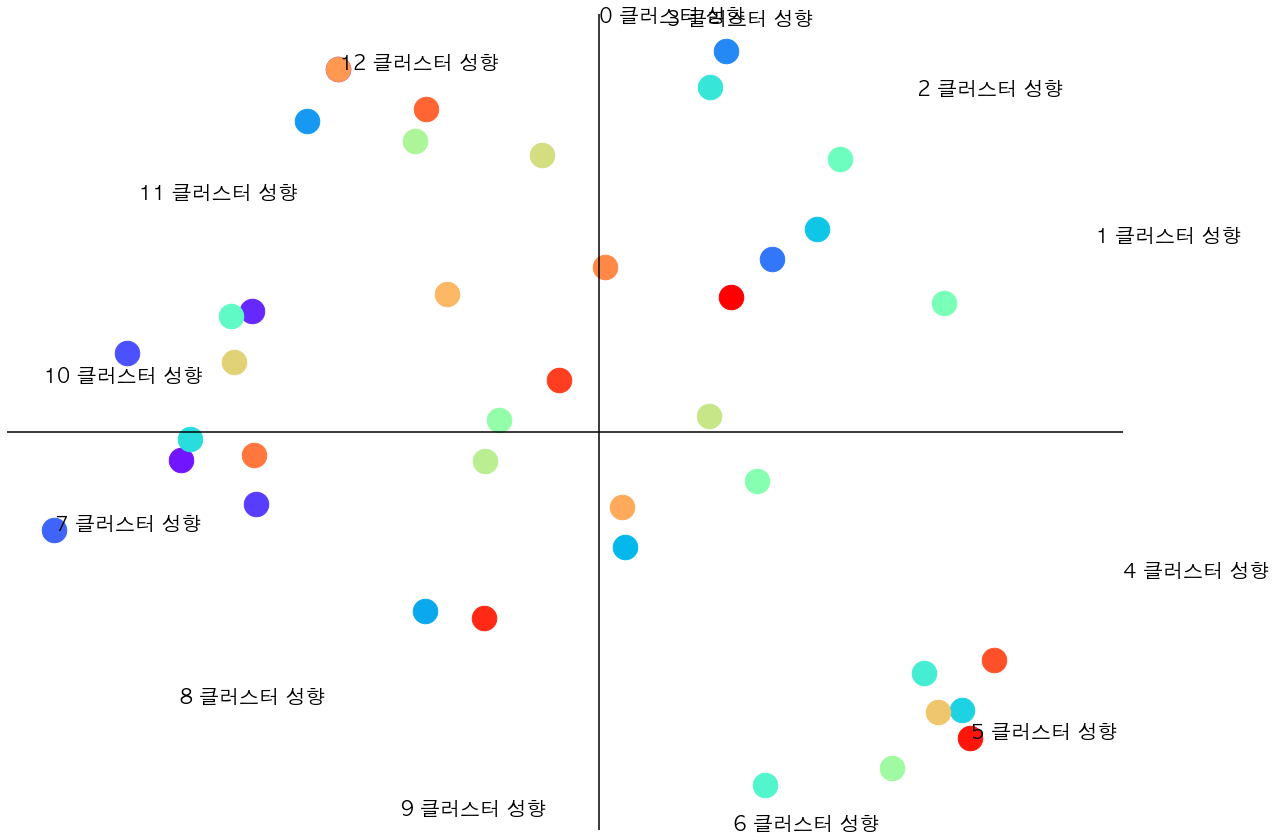

In [160]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(cent_points):
    color = my_palette(idx)
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color=color, label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [161]:
mail_box_points = pd.DataFrame(cent_points, columns=['x','y'])

mail_box_points.index = mail_box_ids
mail_box_points

,x,y
623f2515ff1c441a392ab38c,-46.566613,88.639899
623f2515ff1c441a392ab38d,-74.618871,-6.911270
623f2515ff1c441a392ab38e,-61.873089,29.678776
623f2515ff1c441a392ab38f,-61.140081,-17.458699
623f2515ff1c441a392ab390,-84.169812,19.301981
623f2515ff1c441a392ab391,-97.188478,-23.837270
623f2516ff1c441a392ab392,30.897479,42.210629
623f2516ff1c441a392ab393,22.628294,93.013651
623f2516ff1c441a392ab394,-52.053948,75.939567
623f2516ff1c441a392ab395,-30.971739,-43.555345


# 유사도 확인

In [162]:
rate_x = 100
rate_y = 100

_my_box_id = mail_box_points.iloc[0].name
user_centroid = mail_box_points.iloc[0].values
user_x, user_y = user_centroid

search_box = mail_box_points[
    ((mail_box_points['x'] < (user_x + rate_x)) & (mail_box_points['x'] > (user_x - rate_x))) &
    ((mail_box_points['y'] < (user_y + rate_y)) & (mail_box_points['y'] > (user_y - rate_y)))
]

search_box.head()

,x,y
623f2515ff1c441a392ab38c,-46.566613,88.639899
623f2515ff1c441a392ab38d,-74.618871,-6.911270
623f2515ff1c441a392ab38e,-61.873089,29.678776
623f2515ff1c441a392ab390,-84.169812,19.301981
623f2516ff1c441a392ab392,30.897479,42.210629


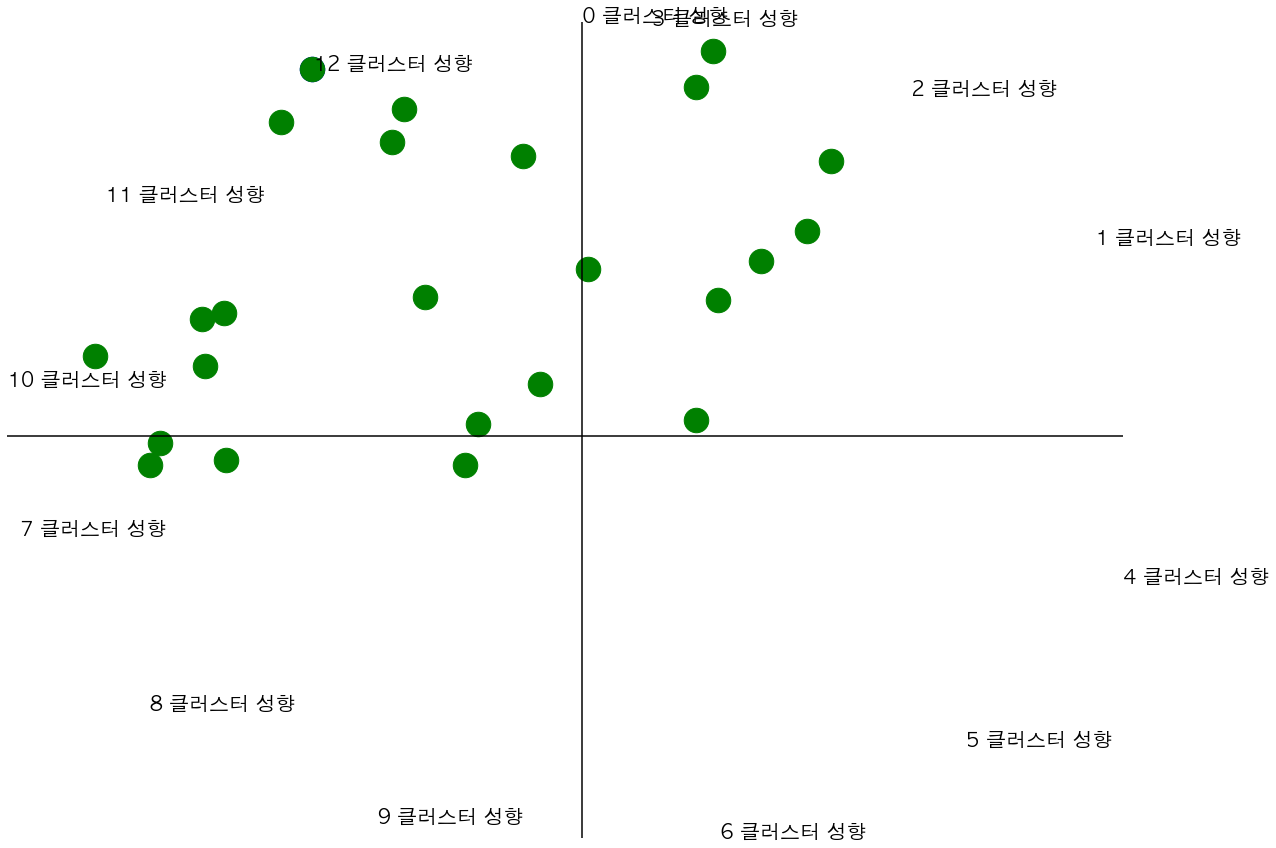

In [163]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [164]:
tracks = pd.DataFrame()
reco_ids = list()

for box in mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c
2,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c
3,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c
4,7KRaeLuGqHJNhU3V3Vw67Z,Dark Night of the Soul,7xaLfXBI5MSy3aNX7m4X3O,Philip Wesley,623f2515ff1c441a392ab38c


In [165]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
1,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38e,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
2,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab394,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
3,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2746ff1c441a392ab40e,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
4,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2abbff1c441a392ab4c4,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436


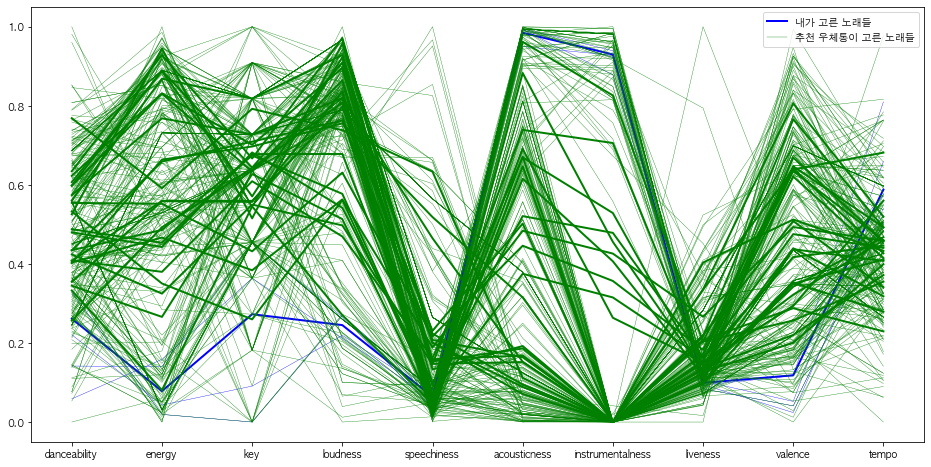

In [166]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [167]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 1.405727987261331


In [168]:
rate_x = 100
rate_y = 100

_my_box_id = mail_box_points.iloc[0].name
user_centroid = mail_box_points.iloc[0].values
user_x, user_y = user_centroid

search_box = mail_box_points[~(
    ((mail_box_points['x'] < (user_x + rate_x)) & (mail_box_points['x'] > (user_x - rate_x))) &
    ((mail_box_points['y'] < (user_y + rate_y)) & (mail_box_points['y'] > (user_y - rate_y)))
)]

search_box = search_box.append(mail_box_points.iloc[0])

search_box.head()

,x,y
623f2515ff1c441a392ab38f,-61.140081,-17.458699
623f2515ff1c441a392ab391,-97.188478,-23.837270
623f2516ff1c441a392ab395,-30.971739,-43.555345
623f2745ff1c441a392ab40a,4.640618,-28.168094
623f2745ff1c441a392ab40c,64.807654,-67.821159


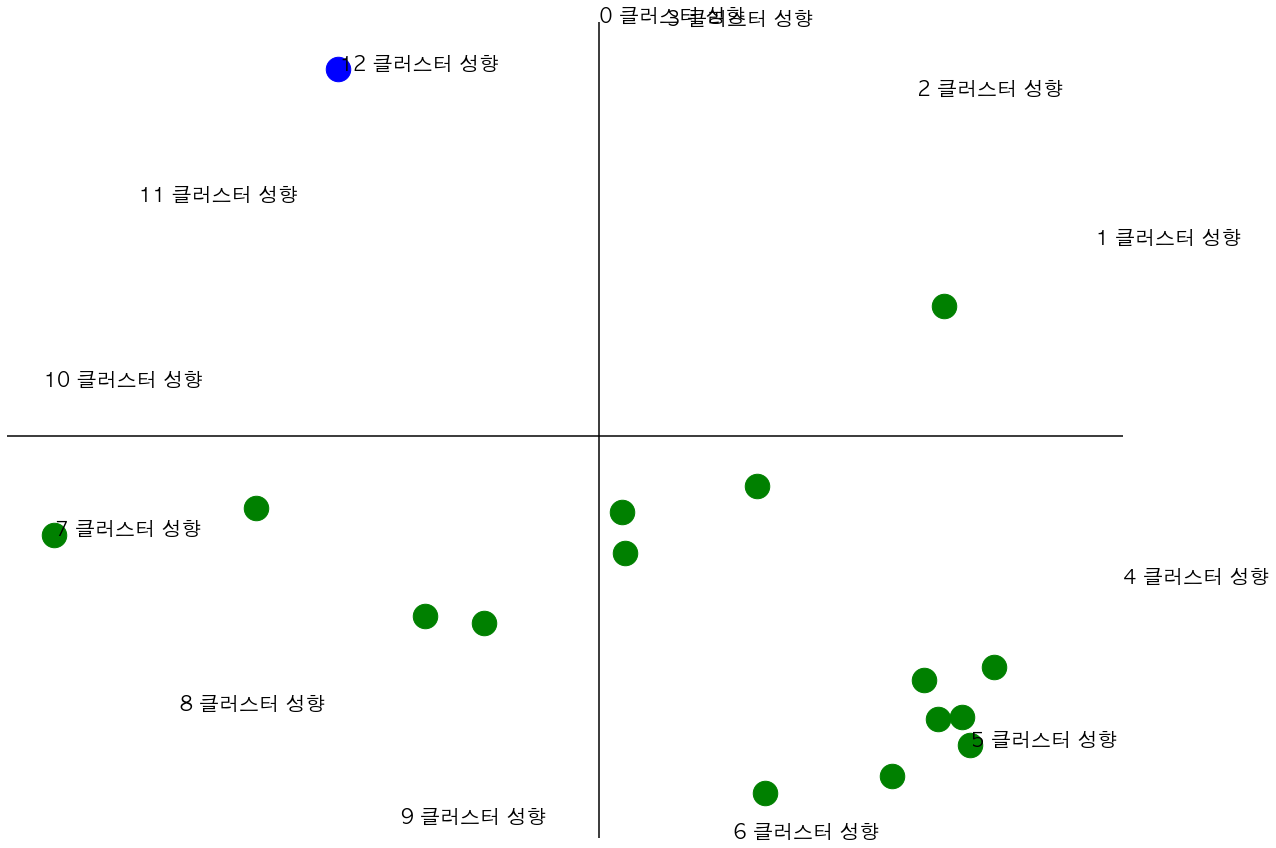

In [169]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [170]:
tracks = pd.DataFrame()
reco_ids = list()

for box in mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c
2,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c
3,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c
4,7KRaeLuGqHJNhU3V3Vw67Z,Dark Night of the Soul,7xaLfXBI5MSy3aNX7m4X3O,Philip Wesley,623f2515ff1c441a392ab38c


In [171]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c,0.557221,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.119325,0.357399,0.426436
1,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab395,0.557221,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.119325,0.357399,0.426436
2,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2e6cff1c441a392ab4f9,0.557221,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.119325,0.357399,0.426436
3,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c,0.141689,0.140150,0.454545,0.265490,0.036117,0.949746,0.927597,0.093277,0.117103,0.809968
4,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c,0.220708,0.042931,0.090909,0.219294,0.071465,0.994975,0.939140,0.094642,0.023921,0.540853


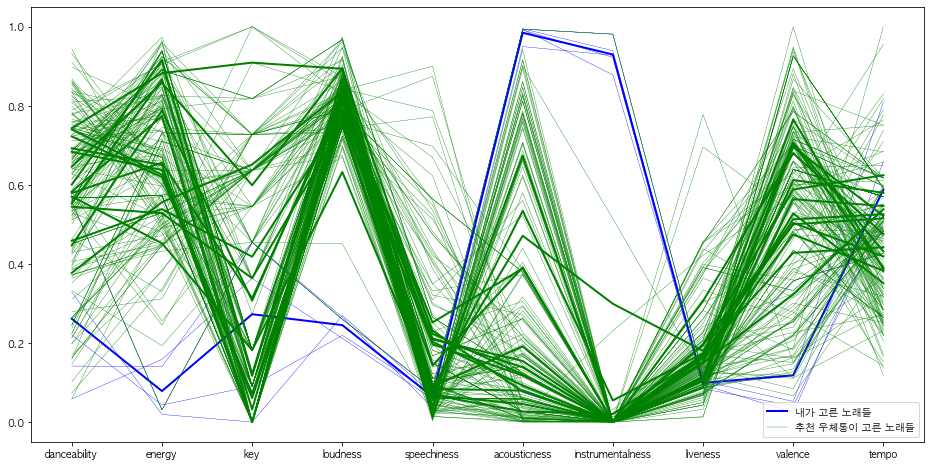

In [172]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [173]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 1.628539077080868
